In [1]:
#imports
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchsummaryX import summary
import warnings

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)
warnings.filterwarnings('ignore')

Device:  cuda


In [2]:
!nvidia-smi

Thu Dec  8 05:57:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# !unzip /content/sonar-data.zip

# Dataset Class

In [3]:
# Dataset
from torch.utils.data.dataset import Dataset
import os, glob
from tqdm import tqdm

# dataset util

def add_keypoint_map(data):
  image_shape = np.shape(data['image'])
  kp = np.floor(data['keypoints']).astype(np.int32)
  kmap = np.zeros(image_shape).astype(np.float32)
  for p in kp:
    kmap[p[0],p[1]] = 1.0
  return {**data, 'keypoint_map': kmap}


# Dataset classes
class SonarDataset(torch.utils.data.Dataset):
    def __init__(self, root, partition= "train"): 
        '''
        Initializes the dataset.
        '''

        # Load the directory and all files in them
        self.train_samples = []

        if partition == "train":
          self.img_dir = root + "/train/img/"
          self.pts_dir = root + "/train/pts/"
        elif partition == 'val':
          self.img_dir = root + "/valid/img/"
          self.pts_dir = root + "/valid/pts/"
        else:
          self.img_dir = root + "/test/img/"
          self.pts_dir = root + "/test/pts/"

        
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''

        img_files = glob.glob(self.img_dir+'/*.png')
        pt_files = glob.glob(self.pts_dir+'/*.npy')

        for idx in tqdm(range(len(img_files))):
            sample = (img_files[idx], pt_files[idx])
            self.train_samples.append(sample)


    def __len__(self):
        return len(self.train_samples)


    def __getitem__(self, index):
        def _read_image(filename):
            image = cv2.imread(filename, 0)
            image = image.astype('float32')
            return image

        def _read_points(filename):
            return np.load(filename).astype(np.float32)
        
        sample = self.train_samples[index]
        image = _read_image(sample[0])
        pts = np.reshape(_read_points(sample[1]), [-1, 2])

        data = {'image': image, 'keypoints': pts}
        data = add_keypoint_map(data)

        # Convert to Tensors
        image = torch.from_numpy(data['image'])
        keypoint_map = torch.from_numpy(data['keypoint_map'])

        image = torch.unsqueeze(image, 0)

        return image, keypoint_map

# Dataloader

In [4]:
# Dataloader

BATCH_SIZE = 16
root = ""

# Create objects for the dataset class
train_data = SonarDataset(root)
val_data = SonarDataset(root,"valid") 
test_data = SonarDataset(root,"test") 

train_loader = torch.utils.data.DataLoader(train_data, num_workers= 0,
                                           batch_size=BATCH_SIZE, 
                                           shuffle= True)
val_loader = torch.utils.data.DataLoader(val_data, num_workers= 0,
                                         batch_size=BATCH_SIZE, 
                                         shuffle= False)
test_loader = torch.utils.data.DataLoader(test_data, num_workers= 2, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle= False)

print("Batch size: ", BATCH_SIZE)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

# sanity check
for data in train_loader:
    img, pts = data
    print(img.shape, pts.shape)
    break 

100%|██████████| 88/88 [00:00<00:00, 323203.81it/s]

Batch size:  16
Train dataset samples = 604, batches = 38
Val dataset samples = 88, batches = 6
Test dataset samples = 88, batches = 6
torch.Size([16, 1, 512, 512]) torch.Size([16, 512, 512])


# Superpoint

In [5]:
class SuperPointNet(torch.nn.Module):
  """ Pytorch definition of SuperPoint Network. """
  def __init__(self):
    super(SuperPointNet, self).__init__()
    self.relu = torch.nn.ReLU(inplace=True)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
    # Shared Encoder.
    self.conv1a = torch.nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
    self.conv1b = torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
    self.conv2a = torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
    self.conv2b = torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
    self.conv3a = torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
    self.conv3b = torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
    self.conv4a = torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
    self.conv4b = torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
    # Detector Head.
    self.convPa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convPb = torch.nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
    # Descriptor Head.
    self.convDa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convDb = torch.nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    """ Forward pass that jointly computes unprocessed point and descriptor
    tensors.
    Input
      x: Image pytorch tensor shaped N x 1 x H x W.
    Output
      semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
      desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
    """
    # Shared Encoder.
    x = self.relu(self.conv1a(x))
    x = self.relu(self.conv1b(x))
    x = self.pool(x)
    x = self.relu(self.conv2a(x))
    x = self.relu(self.conv2b(x))
    x = self.pool(x)
    x = self.relu(self.conv3a(x))
    x = self.relu(self.conv3b(x))
    x = self.pool(x)
    x = self.relu(self.conv4a(x))
    x = self.relu(self.conv4b(x))
    # Detector Head.
    cPa = self.relu(self.convPa(x))
    semi = self.convPb(cPa)
    return semi

In [6]:
# Superpoint
superpoint = SuperPointNet()
superpoint = superpoint.to(DEVICE)
print(superpoint)
summary(superpoint, x=img.to(DEVICE))

SuperPointNet(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv1a,"[1, 64, 3, 3]","[16, 64, 512, 512]",640.0,1.509949e+08
1_relu,-,"[16, 64, 512, 512]",NaN,NaN
2_conv1b,"[64, 64, 3, 3]","[16, 64, 512, 512]",36928.0,9.663676e+09
3_relu,-,"[16, 64, 512, 512]",NaN,NaN
4_pool,-,"[16, 64, 256, 256]",NaN,NaN
5_conv2a,"[64, 64, 3, 3]","[16, 64, 256, 256]",36928.0,2.415919e+09
6_relu,-,"[16, 64, 256, 256]",NaN,NaN
7_conv2b,"[64, 64, 3, 3]","[16, 64, 256, 256]",36928.0,2.415919e+09
8_relu,-,"[16, 64, 256, 256]",NaN,NaN


# Loss

In [7]:
# loss computation

# helper function that converts keypoint mappings to desired shape
class SpaceToDepth(nn.Module):
    '''
    TF Op: tf.nn.space_to_depth
    '''
    def __init__(self, block_size):
        super(SpaceToDepth, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.contiguous().view(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Cross Entropy Loss
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, logits, target):
        return self.loss_fn(logits, target)

class DetectorLoss(nn.Module):
    '''
    Calculates the Error using the CrossEntropyLoss
    Typically the grid_size is 8 so that can do that mapping in the comments
    '''

    def __init__(self, grid_size):
        super(DetectorLoss, self).__init__()

        self.grid_size = grid_size
        self.s2d = SpaceToDepth(self.grid_size)

    def forward(self, logits, keypoint_map):
        '''
        :param logits: Keypoint output from network is format B,C=65,H/8,W/8
        :param keypoint_map: Ground truth keypoint map is of format 1,H,W
        :param valid_mask:
        :return:
        '''
        # Explanation:
        # Model outputs to size C=65,H/8,W/8 . The 65 channels represent the 8x8 grid in the full scale version, +1
        # for the no keypoint bin

        # Modify keypoint map to correct size
        labels = keypoint_map
        labels = labels[:, None, :, :]
        # Convert from 1xHxW to 64xH/8xW/8
        labels = self.s2d.forward(labels)

        new_shape = labels.shape
        # print('labels after s2d', new_shape)
        new_shape = torch.Size((new_shape[0], 1, new_shape[2], new_shape[3]))
        # print('what is this', new_shape)

        # # Here we add an extra channel for the no_keypoint_bin i.e channel 65 with all 1(ones)
        # # And ensure all the keypoint locations have value 2 not 1
        labels = torch.cat((2 * labels, torch.ones(new_shape, device=labels.device)), dim=1)
        # labels is now size B,C=65,H,W
        labels = labels.squeeze(0)
        # print('adding in bin', labels.shape)

        # we now take the argmax of the channels dimension. If there was a keypoint at a channel location then it has the
        # value 2 so its index is the max. If instead though as in most cases there is no keypoint then it will return
        # the 65 channel so index 64
        labels = torch.argmax(labels, dim=1)
        # print('labels after argmax',labels.shape)
        # print('labels', labels.shape)
        # print('logits',logits.shape)

        # Mask the pixels if bordering artifacts appear
        # valid_mask = torch.ones_like(keypoint_map)
        # valid_mask = valid_mask[:, None, :, :].float()
        # valid_mask = self.s2d.forward(valid_mask)
        # valid_mask = torch.prod(valid_mask, dim=1)

        # valid_mask = torch.ones_like(logits) if valid_mask is None else valid_mask
        # valid_mask = valid_mask.float()
        # valid_mask = torch.prod(valid_mask, dim=1)

        loss_fn = nn.CrossEntropyLoss(reduction='none')
        loss = loss_fn(logits, labels)
        #Pytorch cross entropy weight argument works on the classes not the instances. So we just do the mask
        #multiplication at the end
        # print(loss.shape)
        # print(valid_mask.shape)
        # valid_loss=loss*valid_mask
        return loss.mean()
        # return loss

# Trainer

In [8]:
# Trainer
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Device: ", DEVICE)
def train(model, dataloader, criterion, optimizer):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    
    for i, (img, pts) in enumerate(dataloader):

        optimizer.zero_grad()

        img, pts = img.to(DEVICE), pts.to(DEVICE)

        logits = model(img)

        loss = criterion(logits, pts) #[None, :, :])

        running_loss        += loss.item()

        loss.backward()
        optimizer.step()

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()

        del img, pts
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)

    return running_loss

In [9]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0.0

    for i, (img, pts) in enumerate(dataloader):

        img, pts = img.to(DEVICE), pts.to(DEVICE)

        with torch.inference_mode():
            logits = model(img)

        loss = criterion(logits, pts) #[None, :, :])

        val_loss        += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(val_loss/(i+1)))
        batch_bar.update()

        del img, pts
        torch.cuda.empty_cache()

    batch_bar.close()
    val_loss /= len(dataloader)
    scheduler.step(val_loss)

    return val_loss

# Optimizer, Scheduler, Loss

In [10]:
optimizer = torch.optim.Adam(superpoint.parameters(), lr=0.001)
criterion = DetectorLoss(8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5, factor = 0.7, threshold=0.01, verbose=True)

# Wandb

In [11]:
import wandb
wandb.login(key="your key here")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yoonichoi. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
run = wandb.init(
    name = 'superpointrun',
    reinit = True,
    # id = ##,
    # resume = True,
    project = 'superpoint_sonar'
)

# Experiments

In [13]:
best_loss = float('inf')
epochs = 60
current_model_checkpoint = ""
best_model_checkpoint = ""

for epoch in range(epochs):
    
    curr_lr = float(optimizer.param_groups[0]['lr'])

    print("\nEpoch: {}/{}".format(epoch+1, epochs))

    # Call train and validate 
    train_loss = train(superpoint, train_loader, criterion, optimizer)
    val_loss = validate(superpoint, val_loader)

    # Print your metrics
    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Learning Rate {:.04f}".format(
          epoch+1, epochs, train_loss, curr_lr))
    print("Val loss {:.04f}".format(val_loss))


    # Log metrics to Wandb
    wandb.log({"train_loss": train_loss, "learning_rate":curr_lr, "validation_distance":val_loss})

    

    # Optional: Scheduler Step / Teacher Force Schedule Step


    torch.save({'model_state_dict':superpoint.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'val_loss': val_loss, 
                'epoch': epoch}, current_model_checkpoint)

    if val_loss <= best_loss:
        best_loss = val_loss
        # Save your model checkpoint here
        print("Updating Best model")
        torch.save({'model_state_dict':superpoint.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'val_loss': val_loss, 
                    'epoch': epoch}, best_model_checkpoint)
        wandb.save('checkpoint.pth')

run.finish()


Epoch: 1/60



Epoch 1/60: 
Train Loss 0.2549	 Learning Rate 0.0010
Val loss 0.0151
Updating Best model

Epoch: 2/60



Epoch 2/60: 
Train Loss 0.0112	 Learning Rate 0.0010
Val loss 0.0099
Updating Best model

Epoch: 3/60



Epoch 3/60: 
Train Loss 0.0097	 Learning Rate 0.0010
Val loss 0.0097
Updating Best model

Epoch: 4/60



Epoch 4/60: 
Train Loss 0.0096	 Learning Rate 0.0010
Val loss 0.0097
Updating Best model

Epoch: 5/60



Epoch 5/60: 
Train Loss 0.0095	 Learning Rate 0.0010
Val loss 0.0099

Epoch: 6/60



Epoch 6/60: 
Train Loss 0.0095	 Learning Rate 0.0010
Val loss 0.0096
Updating Best model

Epoch: 7/60



Epoch 7/60: 
Train Loss 0.0094	 Learning Rate 0.0010
Val loss 0.0096

Epoch: 8/60



Epoch 8/60: 
Train Loss 0.0094	 Learning Rate 0.0010
Val loss 0.0095
Updating Best model

Epoch: 9/60



Epoch 9/60: 
Train Loss 0.0095	 Learning Rate 0.0010
Val loss 0.0098

Epoch: 10/60



Epoch 10/60: 
Train Loss 0.0094	 Learning Rate 0.0010
Val loss 0.0095

Epoch: 11/60



Epoch 11/60: 
Train Loss 0.0093	 Learning Rate 0.0010
Val loss 0.0095
Updating Best model

Epoch: 12/60



Epoch 12/60: 
Train Loss 0.0093	 Learning Rate 0.0010
Val loss 0.0095

Epoch: 13/60



Epoch 13/60: 
Train Loss 0.0092	 Learning Rate 0.0010
Val loss 0.0094
Updating Best model

Epoch: 14/60


Epoch    14: reducing learning rate of group 0 to 7.0000e-04.

Epoch 14/60: 
Train Loss 0.0092	 Learning Rate 0.0010
Val loss 0.0096

Epoch: 15/60



Epoch 15/60: 
Train Loss 0.0092	 Learning Rate 0.0007
Val loss 0.0095

Epoch: 16/60



Epoch 16/60: 
Train Loss 0.0092	 Learning Rate 0.0007
Val loss 0.0094

Epoch: 17/60



Epoch 17/60: 
Train Loss 0.0091	 Learning Rate 0.0007
Val loss 0.0094
Updating Best model

Epoch: 18/60



Epoch 18/60: 
Train Loss 0.0091	 Learning Rate 0.0007
Val loss 0.0095

Epoch: 19/60



Epoch 19/60: 
Train Loss 0.0092	 Learning Rate 0.0007
Val loss 0.0094

Epoch: 20/60



Epoch 20/60: 
Train Loss 0.0091	 Learning Rate 0.0007
Val loss 0.0094

Epoch: 21/60



Epoch 21/60: 
Train Loss 0.0091	 Learning Rate 0.0007
Val loss 0.0095

Epoch: 22/60



Epoch 22/60: 
Train Loss 0.0091	 Learning Rate 0.0007
Val loss 0.0094

Epoch: 23/60


Epoch    23: reducing learning rate of group 0 to 4.9000e-04.

Epoch 23/60: 
Train Loss 0.0091	 Learning Rate 0.0007
Val loss 0.0094

Epoch: 24/60



Epoch 24/60: 
Train Loss 0.0091	 Learning Rate 0.0005
Val loss 0.0094

Epoch: 25/60



Epoch 25/60: 
Train Loss 0.0091	 Learning Rate 0.0005
Val loss 0.0094

Epoch: 26/60



Epoch 26/60: 
Train Loss 0.0090	 Learning Rate 0.0005
Val loss 0.0094

Epoch: 27/60



Epoch 27/60: 
Train Loss 0.0090	 Learning Rate 0.0005
Val loss 0.0097

Epoch: 28/60



Epoch 28/60: 
Train Loss 0.0091	 Learning Rate 0.0005
Val loss 0.0095

Epoch: 29/60


Epoch    29: reducing learning rate of group 0 to 3.4300e-04.

Epoch 29/60: 
Train Loss 0.0090	 Learning Rate 0.0005
Val loss 0.0095

Epoch: 30/60



Epoch 30/60: 
Train Loss 0.0090	 Learning Rate 0.0003
Val loss 0.0095

Epoch: 31/60



Epoch 31/60: 
Train Loss 0.0090	 Learning Rate 0.0003
Val loss 0.0095

Epoch: 32/60



Epoch 32/60: 
Train Loss 0.0090	 Learning Rate 0.0003
Val loss 0.0095

Epoch: 33/60



Epoch 33/60: 
Train Loss 0.0090	 Learning Rate 0.0003
Val loss 0.0095

Epoch: 34/60



Epoch 34/60: 
Train Loss 0.0090	 Learning Rate 0.0003
Val loss 0.0095

Epoch: 35/60


Epoch    35: reducing learning rate of group 0 to 2.4010e-04.

Epoch 35/60: 
Train Loss 0.0090	 Learning Rate 0.0003
Val loss 0.0095

Epoch: 36/60



Epoch 36/60: 
Train Loss 0.0090	 Learning Rate 0.0002
Val loss 0.0095

Epoch: 37/60



Epoch 37/60: 
Train Loss 0.0090	 Learning Rate 0.0002
Val loss 0.0095

Epoch: 38/60



Epoch 38/60: 
Train Loss 0.0089	 Learning Rate 0.0002
Val loss 0.0095

Epoch: 39/60



Epoch 39/60: 
Train Loss 0.0089	 Learning Rate 0.0002
Val loss 0.0095

Epoch: 40/60



Epoch 40/60: 
Train Loss 0.0089	 Learning Rate 0.0002
Val loss 0.0095

Epoch: 41/60


Epoch    41: reducing learning rate of group 0 to 1.6807e-04.

Epoch 41/60: 
Train Loss 0.0089	 Learning Rate 0.0002
Val loss 0.0095

Epoch: 42/60



Epoch 42/60: 
Train Loss 0.0089	 Learning Rate 0.0002
Val loss 0.0095

Epoch: 43/60



Epoch 43/60: 
Train Loss 0.0089	 Learning Rate 0.0002
Val loss 0.0095

Epoch: 44/60



Epoch 44/60: 
Train Loss 0.0089	 Learning Rate 0.0002
Val loss 0.0096

Epoch: 45/60



Epoch 45/60: 
Train Loss 0.0089	 Learning Rate 0.0002
Val loss 0.0096

Epoch: 46/60



Epoch 46/60: 
Train Loss 0.0089	 Learning Rate 0.0002
Val loss 0.0096

Epoch: 47/60


Epoch    47: reducing learning rate of group 0 to 1.1765e-04.

Epoch 47/60: 
Train Loss 0.0089	 Learning Rate 0.0002
Val loss 0.0096

Epoch: 48/60



Epoch 48/60: 
Train Loss 0.0089	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 49/60



Epoch 49/60: 
Train Loss 0.0088	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 50/60



Epoch 50/60: 
Train Loss 0.0089	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 51/60



Epoch 51/60: 
Train Loss 0.0088	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 52/60



Epoch 52/60: 
Train Loss 0.0088	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 53/60


Epoch    53: reducing learning rate of group 0 to 8.2354e-05.

Epoch 53/60: 
Train Loss 0.0088	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 54/60



Epoch 54/60: 
Train Loss 0.0088	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 55/60



Epoch 55/60: 
Train Loss 0.0088	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 56/60



Epoch 56/60: 
Train Loss 0.0088	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 57/60



Epoch 57/60: 
Train Loss 0.0088	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 58/60



Epoch 58/60: 
Train Loss 0.0088	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 59/60


Epoch    59: reducing learning rate of group 0 to 5.7648e-05.

Epoch 59/60: 
Train Loss 0.0088	 Learning Rate 0.0001
Val loss 0.0096

Epoch: 60/60



Epoch 60/60: 
Train Loss 0.0088	 Learning Rate 0.0001
Val loss 0.0097


learning_rate,██████████▆▆▆▆▆▆▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_distance,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,6e-05
train_loss,0.00879
validation_distance,0.00965


# Testing

In [16]:
def testing():
    superpoint.eval()
    total_loss = 0
    
    batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, position=0, leave=False, desc='Test')
    for i, (img, pts) in enumerate(test_loader):

        img, pts = img.to(DEVICE), pts.to(DEVICE)

        with torch.no_grad():
            prediction = superpoint(img)
            loss = criterion(prediction, pts)
            batch_size = img.shape[0]
            total_loss += loss.item() * batch_size
        break
        batch_bar.update()
    return total_loss / len(test_loader)

In [17]:
testing()

0.02585781862338384

In [18]:
for data in test_loader:
    img, pts = data
    print(img.shape, pts.shape)
    break 

torch.Size([16, 1, 512, 512]) torch.Size([16, 512, 512])


AxesImage(54,36;334.8x217.44)


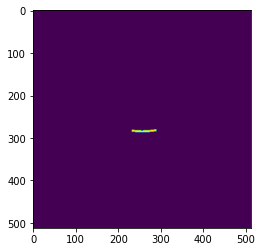

In [27]:
# visualization
import matplotlib.pyplot as plt
# original image
print(plt.imshow(img.detach().cpu().numpy()[0,0]))

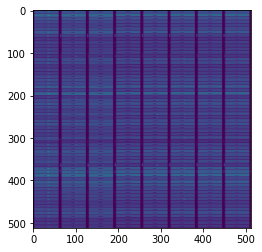

In [22]:
# using the model output
sftmax = nn.Softmax(1)
testoutput = superpoint(img.to(DEVICE))
test_softmax = sftmax(testoutput)
tst = test_softmax[:,:64,:,:].reshape(16,512,512)
tst_cpu = tst.detach().cpu().numpy()
plt.imshow(tst_cpu[0])